# Kaggle Project

## 데이터 설명
**URL**: https://www.kaggle.com/datasets/phylake1337/fire-dataset

**Task**
1. 커스텀 데이터셋 클래스 정의
2. 데이터셋 생성 및 데이터로더 정의
3. 샘플이미지 출력하여 데이터 확인
4. 데이터 분할 및 DataLoader 설정
5. 모델 정의: CNN
6. 평가 함수 정의
7. 학습 및 검증
8. Test 데이터를 사용하여 최종 성능 평가

**Datasets**
데이터셋은 두 종류의 이미지로 구성되어있음
1. fire_images: 화재 이미지
2. non_fire_images: 비화재 이미지

데이터셋 분할은 아래와 같음
- Train: 60%
- Validation: 20%
- Test: 20%

**Features(x)**

URL에서 받은 Datasets

**Target(y)**
- 화재: 1
- 비화재: 0

## 0. Import Library & 설정 값 정의

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToPILImage
from IPython.display import display
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
import matplotlib.pyplot as plt

# CUDA 사용 가능 여부 확인
USE_CUDA = torch.cuda.is_available()
# DEVICE 설정 (GPU 사용 가능 시 GPU 사용, 불가능 시 CPU 사용)
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
# 학습 설정 값
EPOCHS = 40
BATCH_SIZE = 64

## 1. 커스텀 데이터셋 클래스 정의

In [2]:
class CustomDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.fire_images = []
        self.non_fire_images = []

        # 화재 이미지 경로 설정
        fire_path = './fire_dataset/fire_images'
        fire_files = os.listdir(fire_path)
        for f in fire_files:
            img = Image.open(os.path.join(fire_path, f)).convert('RGB')
            self.fire_images.append(img)

        # 비화재 이미지 경로 설정
        non_fire_path = './fire_dataset/non_fire_images'
        non_fire_files = os.listdir(non_fire_path)
        for f in non_fire_files:
            img = Image.open(os.path.join(non_fire_path, f)).convert('RGB')
            self.non_fire_images.append(img)

    def __len__(self):
        # 데이터셋 전체 크기 반환
        return len(self.fire_images) + len(self.non_fire_images)

    def __getitem__(self, idx):
        if idx < len(self.fire_images):
            # idx가 화재 이미지의 개수보다 작으면 화재 이미지를 반환
            img = self.fire_images[idx]
            label = torch.tensor(1)  # 1: fire_images
        else:
            # idx가 화재 이미지의 개수 이상이면 비화재 이미지를 반환
            img = self.non_fire_images[idx - len(self.fire_images)]
            label = torch.tensor(0)  # 0: non_fire_images

        if self.transform:
            # 데이터셋 변환을 위한 transform이 설정되어 있으면 반환
            img = self.transform(img)

        return img, label

## 2. 데이터셋 생성 및 데이터로더 정의

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)), # img 크기를 (64, 64)로 변환
    transforms.ToTensor(),       # img를 Tensor로 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #정규화
])

# Custom 데이터셋 생성
dataset = CustomDataset(transform=transform)

## 3. 샘플이미지 출력하여 데이터 확인

Fire Image 1


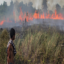

Fire Image 2


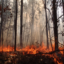

Fire Image 3


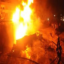

Fire Image 4


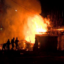

Non-Fire Image 1


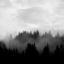

Non-Fire Image 2


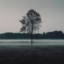

Non-Fire Image 3


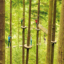

Non-Fire Image 4


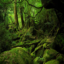

In [4]:
# 샘플 이미지 가져오기
fire_count = 0
non_fire_count = 0

# 샘플 이미지 출력 개수 정의
PRINT_NUM = 4

# 샘플 이미지 출력
for i in range(len(dataset)):
    sample_image, sample_label = dataset[i]
    
    if sample_label == 1 and fire_count < PRINT_NUM:
        # 화재 이미지 출력
        to_pil = ToPILImage()
        sample_image = to_pil(sample_image * 0.5 + 0.5)
        print(f"Fire Image {fire_count + 1}")
        display(sample_image)
        fire_count += 1
        
    elif sample_label == 0 and non_fire_count < PRINT_NUM:
        # 비화재 이미지 출력
        to_pil = ToPILImage()
        sample_image = to_pil(sample_image * 0.5 + 0.5)
        print(f"Non-Fire Image {non_fire_count + 1}")
        display(sample_image)
        non_fire_count += 1
        
    if fire_count >= PRINT_NUM and non_fire_count >= PRINT_NUM:
        # 화재와 비화재 이미지가 모두 4장씩 출력되면 종료
        break

## 4. 데이터 분할 및 DataLoader 설정
### (Train: 60%, Validation: 20%, Test: 20%)

In [5]:
train_size = int(0.6 * len(dataset))
val_size = test_size = int(0.2 * len(dataset))
if train_size + val_size + test_size != len(dataset):
    test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 5. 모델 정의: CNN

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        # Convolutional -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = torch.sigmoid(self.fc2(x))
        return x

In [7]:
# 모델 생성 및 모델을 CUDA 디바이스로 전송
model = Net().to(DEVICE)

# 손실함수 정의
criterion = nn.BCELoss()

# Optimizer 정의 및 모델의 파라미터를 인자로 전달
optimizer = optim.Adam(model.parameters())

## 6. 평가 함수 정의

In [8]:
def eval_net(loader, model, criterion, device):
    # 모델을 평가 모드로 설정
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        # DataLoader를 이용해 배치 단위로 데이터를 가져와 평가 진행
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            total_loss += loss.item()
            # 모델의 출력값을 반올림하여 예측값 계산
            predicted = torch.round(outputs.data)
            total += labels.size(0)
            # 예측값과 실제값이 일치하는 경우 정확도 증가
            correct += (predicted == labels.unsqueeze(1)).sum().item()

    # 정확도와 평균 손실 반환
    accuracy = 100 * correct / total
    return accuracy, total_loss / len(loader)

## 7. 학습 및 검증

In [9]:
for epoch in range(EPOCHS):
    # 모델을 학습 모드로 설정
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1)) # 오차 계산
        loss.backward()
        optimizer.step() # 매개변수 업데이트
        running_loss += loss.item()

    # 훈련 데이터와 검증 데이터의 정확도와 손실을 계산
    train_accuracy, train_loss = eval_net(train_loader, model, criterion, DEVICE)
    val_accuracy, val_loss = eval_net(val_loader, model, criterion, DEVICE)
    
    # 현재 epoch의 훈련과 검증 결과를 출력
    print('[Epoch %d] loss: %.3f, train_accuracy: %.2f%%, val_loss: %.3f, val_accuracy: %.2f%%'
          % (epoch + 1, running_loss / len(train_loader), train_accuracy, val_loss, val_accuracy))

print('Finished Training')

[Epoch 1] loss: 0.560, train_accuracy: 73.96%, val_loss: 0.353, val_accuracy: 73.37%
[Epoch 2] loss: 0.320, train_accuracy: 93.99%, val_loss: 0.245, val_accuracy: 93.47%
[Epoch 3] loss: 0.224, train_accuracy: 87.65%, val_loss: 0.258, val_accuracy: 88.44%
[Epoch 4] loss: 0.171, train_accuracy: 94.16%, val_loss: 0.141, val_accuracy: 92.96%
[Epoch 5] loss: 0.126, train_accuracy: 96.99%, val_loss: 0.090, val_accuracy: 94.97%
[Epoch 6] loss: 0.102, train_accuracy: 97.66%, val_loss: 0.108, val_accuracy: 95.48%
[Epoch 7] loss: 0.080, train_accuracy: 96.16%, val_loss: 0.125, val_accuracy: 93.47%
[Epoch 8] loss: 0.067, train_accuracy: 97.83%, val_loss: 0.098, val_accuracy: 94.97%
[Epoch 9] loss: 0.073, train_accuracy: 95.49%, val_loss: 0.151, val_accuracy: 93.47%
[Epoch 10] loss: 0.067, train_accuracy: 97.66%, val_loss: 0.110, val_accuracy: 93.47%
[Epoch 11] loss: 0.059, train_accuracy: 98.33%, val_loss: 0.101, val_accuracy: 95.98%
[Epoch 12] loss: 0.047, train_accuracy: 96.83%, val_loss: 0.152

## 8. Test 데이터를 사용하여 최종 성능 평가

In [10]:
test_accuracy, test_loss = eval_net(test_loader, model, criterion, DEVICE)
print('Test Loss: %.3f, Test Accuracy: %.2f%%' % (test_loss, test_accuracy))

Test Loss: 0.244, Test Accuracy: 98.51%
